In [50]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, isnan, when, abs, avg
spark = SparkSession.builder.appName('Stock Data').getOrCreate()

Loading file in dataframe

In [51]:
dataset = spark.read.csv('AMZN_data.csv', inferSchema=True, header=True)

In [52]:
dataset.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [53]:
dataset.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)



In [54]:
dataset.show()

+----------+--------+--------+--------+--------+---------+----------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|
+----------+--------+--------+--------+--------+---------+----------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 318744000|
|1997-05-27|0.075521|0.082292|0.072917|0.079167| 0.079167| 173952000|
|1997-05-28| 0.08125|0.081771|0.076563|0.076563| 0.076563|  91488000|
|1997-05-29|0.077083|0.077083|0.073958| 0.07526|  0.07526|  69456000|
|1997-05-30|   0.075|0.075521|0.073958|   0.075|    0.075|  51888000|
|1997-06-02|0.075521

In [55]:
null_checks = [count(when(col(c).isNull(), c)).alias(c) for c in dataset.columns]
dataset.select(null_checks).show()

+----+----+----+---+-----+---------+------+
|Date|Open|High|Low|Close|Adj Close|Volume|
+----+----+----+---+-----+---------+------+
|   0|   0|   0|  0|    0|        0|     0|
+----+----+----+---+-----+---------+------+



In [56]:
from pyspark.ml.linalg import Vector
from pyspark.ml.feature import VectorAssembler

In [57]:
featureassembler=VectorAssembler(inputCols=["Open", "High", "Low"], outputCol='Features')

In [58]:
output=featureassembler.transform(dataset)

In [59]:
output.show()

+----------+--------+--------+--------+--------+---------+----------+--------------------+
|      Date|    Open|    High|     Low|   Close|Adj Close|    Volume|            Features|
+----------+--------+--------+--------+--------+---------+----------+--------------------+
|1997-05-15|0.121875|   0.125|0.096354|0.097917| 0.097917|1443120000|[0.121875,0.125,0...|
|1997-05-16|0.098438|0.098958|0.085417|0.086458| 0.086458| 294000000|[0.098438,0.09895...|
|1997-05-19|0.088021|0.088542| 0.08125|0.085417| 0.085417| 122136000|[0.088021,0.08854...|
|1997-05-20|0.086458|  0.0875|0.081771|0.081771| 0.081771| 109344000|[0.086458,0.0875,...|
|1997-05-21|0.081771|0.082292| 0.06875|0.071354| 0.071354| 377064000|[0.081771,0.08229...|
|1997-05-22|0.071875|0.072396|0.065625|0.069792| 0.069792| 235536000|[0.071875,0.07239...|
|1997-05-23|0.070313|0.076042|0.066667|   0.075|    0.075| 318744000|[0.070313,0.07604...|
|1997-05-27|0.075521|0.082292|0.072917|0.079167| 0.079167| 173952000|[0.075521,0.08229...|

In [60]:
output.select(['Features']).show()

+--------------------+
|            Features|
+--------------------+
|[0.121875,0.125,0...|
|[0.098438,0.09895...|
|[0.088021,0.08854...|
|[0.086458,0.0875,...|
|[0.081771,0.08229...|
|[0.071875,0.07239...|
|[0.070313,0.07604...|
|[0.075521,0.08229...|
|[0.08125,0.081771...|
|[0.077083,0.07708...|
|[0.075,0.075521,0...|
|[0.075521,0.07656...|
|[0.076563,0.07656...|
|[0.073958,0.07447...|
|[0.070833,0.07708...|
|[0.075781,0.08541...|
|[0.082813,0.08541...|
|[0.085417,0.08541...|
|[0.079688,0.08020...|
|[0.079167,0.08229...|
+--------------------+
only showing top 20 rows



In [61]:
output.columns

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Features']

In [62]:
final_data=output.select("Date", "Features", "Close").sort("Date", ascending=True)

In [63]:
final_data.show()

+----------+--------------------+--------+
|      Date|            Features|   Close|
+----------+--------------------+--------+
|1997-05-15|[0.121875,0.125,0...|0.097917|
|1997-05-16|[0.098438,0.09895...|0.086458|
|1997-05-19|[0.088021,0.08854...|0.085417|
|1997-05-20|[0.086458,0.0875,...|0.081771|
|1997-05-21|[0.081771,0.08229...|0.071354|
|1997-05-22|[0.071875,0.07239...|0.069792|
|1997-05-23|[0.070313,0.07604...|   0.075|
|1997-05-27|[0.075521,0.08229...|0.079167|
|1997-05-28|[0.08125,0.081771...|0.076563|
|1997-05-29|[0.077083,0.07708...| 0.07526|
|1997-05-30|[0.075,0.075521,0...|   0.075|
|1997-06-02|[0.075521,0.07656...|0.075521|
|1997-06-03|[0.076563,0.07656...|0.073958|
|1997-06-04|[0.073958,0.07447...|0.070833|
|1997-06-05|[0.070833,0.07708...|0.077083|
|1997-06-06|[0.075781,0.08541...|0.082813|
|1997-06-09|[0.082813,0.08541...|0.084375|
|1997-06-10|[0.085417,0.08541...|0.079167|
|1997-06-11|[0.079688,0.08020...|0.077083|
|1997-06-12|[0.079167,0.08229...|0.080208|
+----------

In [64]:
train_data, test_data=final_data.randomSplit([0.75,0.25])
print(f"""There are {train_data.count()} rows in the trainning set,
      and {test_data.count()} in the test set""")

There are 5003 rows in the trainning set,
      and 1711 in the test set


Linear Regression model

In [65]:
from pyspark.ml.regression import LinearRegression

In [66]:
regressor=LinearRegression(featuresCol='Features', labelCol='Close')
lr_model=regressor.fit(train_data)

In [67]:
lr_model.coefficients

DenseVector([-0.6393, 0.8499, 0.7891])

In [68]:
lr_model.intercept

0.008047822331497846

Test

In [69]:
pred_test1=lr_model.transform(test_data)
pred_test1.select("Features", "Close", "Prediction").show()

+--------------------+--------+-------------------+
|            Features|   Close|         Prediction|
+--------------------+--------+-------------------+
|[0.098438,0.09895...|0.086458|0.09662012871874329|
|[0.077083,0.07708...| 0.07526|0.08263910485448475|
|[0.076563,0.07656...|0.073958|0.08252960315016478|
|[0.08125,0.08125,...|0.079167|0.08762693494124957|
|[0.075521,0.07656...|0.075521|0.08401802810516892|
|[0.076563,0.07760...|0.076302|0.08423660274788675|
|[0.076042,0.07604...|0.075521|0.08344727919216033|
|[0.075521,0.07994...|0.077083|0.08607280241462476|
|[0.075781,0.07968...|0.079427|0.08691893102130019|
|[0.091667,0.10104...|     0.1|0.10765216737487449|
|[0.115104,0.11927...|0.116146|0.12542234784875472|
|[0.122396,0.12474...|0.116667|0.12664103334208687|
|[0.117188,0.11718...|0.110938| 0.1177988875437905|
|[0.117188,0.12083...|0.120833|0.12459530915093736|
|[0.110417,0.11562...|  0.1125| 0.1220320156553919|
|[0.1125,0.113021,...|0.108854|0.11602115973511373|
|[0.111458,0

In [70]:
from pyspark.ml.evaluation import RegressionEvaluator

In [71]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="mse")
mse = evaluator.evaluate(pred_test1)
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
r2 = evaluator_r2.evaluate(pred_test1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  0.21816161633810296 
r2:  0.9999186047767804 



In [72]:
pred_test1=pred_test1.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_test1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  1.0405752773729184


In [73]:
pandas_df1 = pred_test1.select("Close", "Prediction").toPandas()

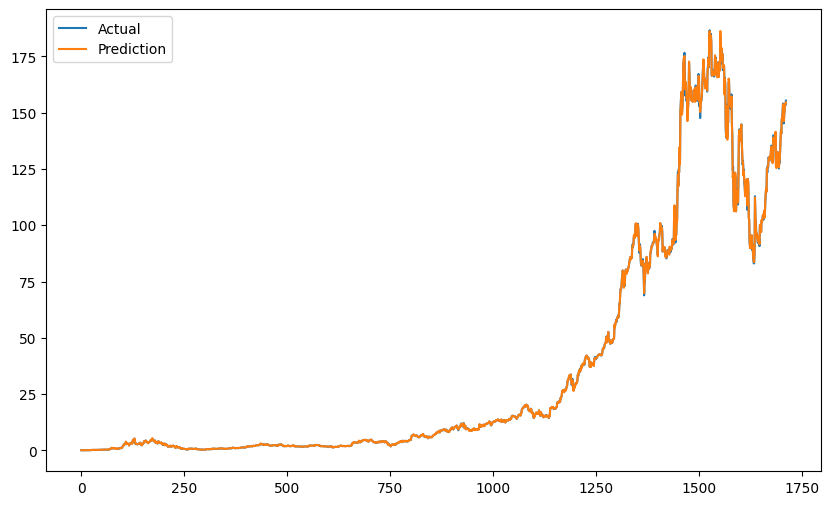

In [74]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pandas_df1['Close'], label='Actual')
plt.plot(pandas_df1['Prediction'], label='Prediction')
plt.legend()
plt.show()

Train

In [75]:
pred_train1=lr_model.transform(train_data)
pred_train1.select("Features", "Close", "Prediction").show()

+--------------------+--------+-------------------+
|            Features|   Close|         Prediction|
+--------------------+--------+-------------------+
|[0.121875,0.125,0...|0.097917|0.11239977471259222|
|[0.088021,0.08854...|0.085417|0.09113924859956343|
|[0.086458,0.0875,...|0.081771|0.09166403650802435|
|[0.081771,0.08229...|0.071354| 0.0799595631433738|
|[0.071875,0.07239...|0.069792| 0.0754097716774986|
|[0.070313,0.07604...|   0.075|0.08032948799128772|
|[0.075521,0.08229...|0.079167|0.08724359250620217|
|[0.08125,0.081771...|0.076563|0.08601496990268623|
|[0.075,0.075521,0...|   0.075|0.08264327791107201|
|[0.075521,0.07656...|0.075521|0.08401802810516892|
|[0.073958,0.07447...|0.070833|0.07913652633107368|
|[0.070833,0.07708...|0.077083|0.08252546481555523|
|[0.075781,0.08541...|0.082813|0.09178815892781206|
|[0.082813,0.08541...|0.084375| 0.0930462828889724|
|[0.085417,0.08541...|0.079167|0.08644964598418134|
|[0.079688,0.08020...|0.077083|0.08568519370300176|
|[0.079167,0

In [76]:
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="mse")
mse = evaluator.evaluate(pred_train1)
evaluator_r2 = RegressionEvaluator(predictionCol="prediction", labelCol="Close", metricName="r2")
r2 = evaluator_r2.evaluate(pred_train1)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  0.18340917513962146 
r2:  0.9999260734434103 



In [77]:
pred_train1=pred_train1.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_train1.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  1.0175006770283517


In [78]:
pandas_df1 = pred_train1.select("Close", "Prediction").toPandas()

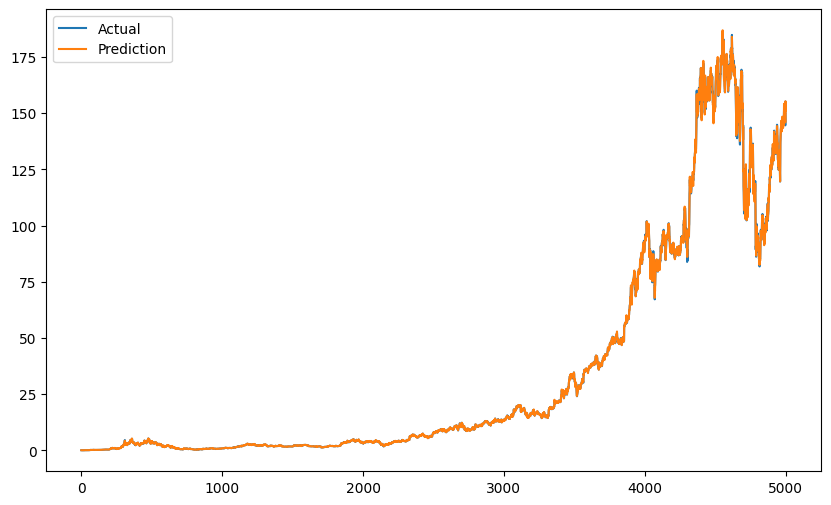

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df1['Close'], label='Actual')
plt.plot(pandas_df1['Prediction'], label='Prediction')
plt.legend()
plt.show()

Random Forest Regressor model

In [80]:
from pyspark.ml.regression import RandomForestRegressor

In [81]:
rf=RandomForestRegressor(featuresCol='Features', labelCol='Close')
rf_model=rf.fit(train_data)

Test

In [82]:
pred_test2=rf_model.transform(test_data)
pred_test2.select("Features", "Close", "Prediction").show()

+--------------------+--------+------------------+
|            Features|   Close|        Prediction|
+--------------------+--------+------------------+
|[0.098438,0.09895...|0.086458|0.7056398237114025|
|[0.077083,0.07708...| 0.07526|0.7056398237114025|
|[0.076563,0.07656...|0.073958|0.7056398237114025|
|[0.08125,0.08125,...|0.079167|0.7056398237114025|
|[0.075521,0.07656...|0.075521|0.7056398237114025|
|[0.076563,0.07760...|0.076302|0.7056398237114025|
|[0.076042,0.07604...|0.075521|0.7056398237114025|
|[0.075521,0.07994...|0.077083|0.7056398237114025|
|[0.075781,0.07968...|0.079427|0.7056398237114025|
|[0.091667,0.10104...|     0.1|0.7056398237114025|
|[0.115104,0.11927...|0.116146|0.7056398237114025|
|[0.122396,0.12474...|0.116667|0.7056398237114025|
|[0.117188,0.11718...|0.110938|0.7056398237114025|
|[0.117188,0.12083...|0.120833|0.7056398237114025|
|[0.110417,0.11562...|  0.1125|0.7056398237114025|
|[0.1125,0.113021,...|0.108854|0.7056398237114025|
|[0.111458,0.11145...|0.109896|

In [83]:
mse = evaluator.evaluate(pred_test2)
r2 = evaluator_r2.evaluate(pred_test2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  7.118243054178128 
r2:  0.9973442120935342 



In [84]:
pred_test2=pred_test2.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_test2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  23.096538793048712


In [100]:
pandas_df2 = pred_test2.select("Close", "Prediction").toPandas()

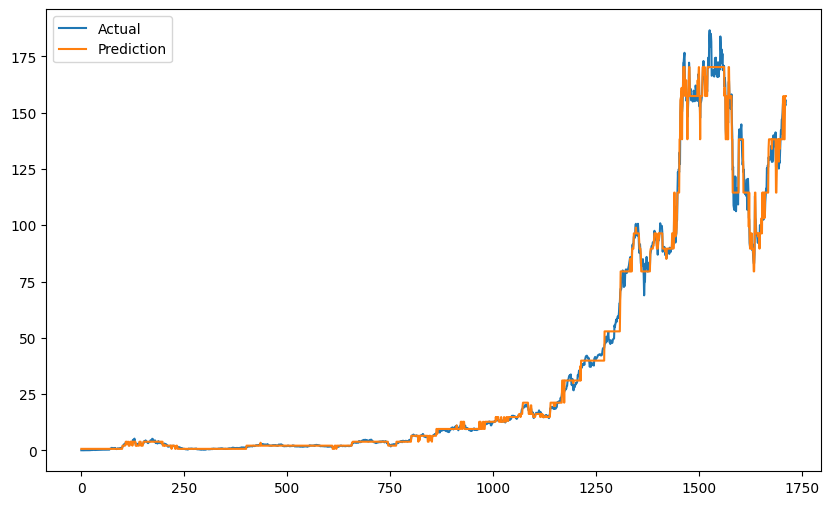

In [103]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df2['Close'], label='Actual')
plt.plot(pandas_df2['Prediction'], label='Prediction')
plt.legend()
plt.show()

Train

In [87]:
pred_train2=rf_model.transform(train_data)
pred_train2.select("Features", "Close", "Prediction").show()

+--------------------+--------+------------------+
|            Features|   Close|        Prediction|
+--------------------+--------+------------------+
|[0.121875,0.125,0...|0.097917|0.7056398237114025|
|[0.088021,0.08854...|0.085417|0.7056398237114025|
|[0.086458,0.0875,...|0.081771|0.7056398237114025|
|[0.081771,0.08229...|0.071354|0.7056398237114025|
|[0.071875,0.07239...|0.069792|0.7056398237114025|
|[0.070313,0.07604...|   0.075|0.7056398237114025|
|[0.075521,0.08229...|0.079167|0.7056398237114025|
|[0.08125,0.081771...|0.076563|0.7056398237114025|
|[0.075,0.075521,0...|   0.075|0.7056398237114025|
|[0.075521,0.07656...|0.075521|0.7056398237114025|
|[0.073958,0.07447...|0.070833|0.7056398237114025|
|[0.070833,0.07708...|0.077083|0.7056398237114025|
|[0.075781,0.08541...|0.082813|0.7056398237114025|
|[0.082813,0.08541...|0.084375|0.7056398237114025|
|[0.085417,0.08541...|0.079167|0.7056398237114025|
|[0.079688,0.08020...|0.077083|0.7056398237114025|
|[0.079167,0.08229...|0.080208|

In [88]:
mse = evaluator.evaluate(pred_train2)
r2 = evaluator_r2.evaluate(pred_train2)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  6.864427815201577 
r2:  0.9972331618036556 



In [89]:
pred_train2=pred_train2.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_train2.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  22.331550634811094


In [104]:
pandas_df2 = pred_train2.select("Close", "Prediction").toPandas()

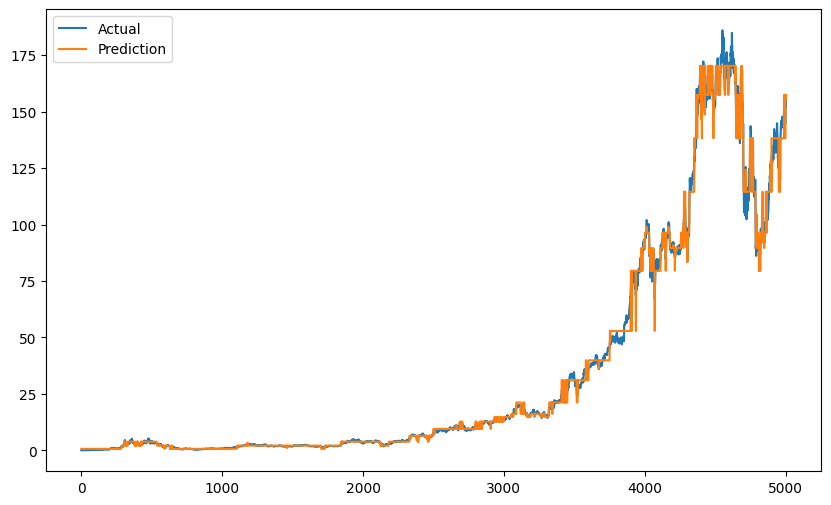

In [105]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df2['Close'], label='Actual')
plt.plot(pandas_df2['Prediction'], label='Prediction')
plt.legend()
plt.show()

Gradient-Boosted Tree Regression

In [90]:
from pyspark.ml.regression import GBTRegressor

In [91]:
gbt = GBTRegressor(featuresCol='Features', labelCol='Close', maxIter=10)
gbt_model = gbt.fit(train_data)

In [106]:
pred_test3=gbt_model.transform(test_data)
pred_test3.select("Features", "Close", "Prediction").show(truncate=False)

+----------------------------+--------+-------------------+
|Features                    |Close   |Prediction         |
+----------------------------+--------+-------------------+
|[0.098438,0.098958,0.085417]|0.086458|0.28339932573033494|
|[0.077083,0.077083,0.073958]|0.07526 |0.28339932573033494|
|[0.076563,0.076563,0.073958]|0.073958|0.28339932573033494|
|[0.08125,0.08125,0.079167]  |0.079167|0.28339932573033494|
|[0.075521,0.076563,0.075]   |0.075521|0.28339932573033494|
|[0.076563,0.077604,0.075]   |0.076302|0.28339932573033494|
|[0.076042,0.076042,0.07526] |0.075521|0.28339932573033494|
|[0.075521,0.079948,0.073958]|0.077083|0.28339932573033494|
|[0.075781,0.079688,0.075521]|0.079427|0.28339932573033494|
|[0.091667,0.101042,0.091667]|0.1     |0.28339932573033494|
|[0.115104,0.119271,0.113542]|0.116146|0.28339932573033494|
|[0.122396,0.12474,0.115104] |0.116667|0.28339932573033494|
|[0.117188,0.117188,0.107813]|0.110938|0.28339932573033494|
|[0.117188,0.120833,0.1125]  |0.120833|0

In [108]:
mse = evaluator.evaluate(pred_test3)
r2 = evaluator_r2.evaluate(pred_test3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  7.285507006353805 
r2:  0.9972818065844788 



In [111]:
pred_test3=pred_test3.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_test3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  8.887560922867028


In [112]:
pandas_df3 = pred_test3.select("Close", "Prediction").toPandas()

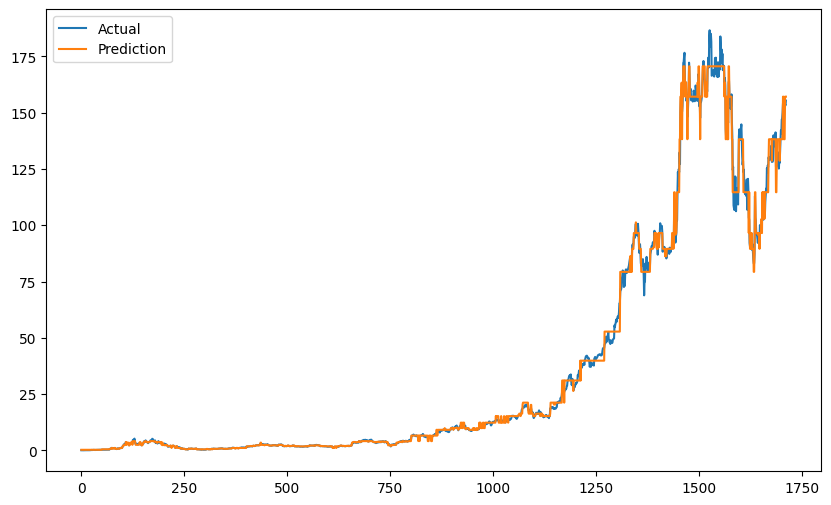

In [113]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df3['Close'], label='Actual')
plt.plot(pandas_df3['Prediction'], label='Prediction')
plt.legend()
plt.show()

Train

In [107]:
pred_train3=gbt_model.transform(train_data)
pred_train3.select("Features", "Close", "Prediction").show(truncate=False)

+----------------------------+--------+-------------------+
|Features                    |Close   |Prediction         |
+----------------------------+--------+-------------------+
|[0.121875,0.125,0.096354]   |0.097917|0.28339932573033494|
|[0.088021,0.088542,0.08125] |0.085417|0.28339932573033494|
|[0.086458,0.0875,0.081771]  |0.081771|0.28339932573033494|
|[0.081771,0.082292,0.06875] |0.071354|0.28339932573033494|
|[0.071875,0.072396,0.065625]|0.069792|0.28339932573033494|
|[0.070313,0.076042,0.066667]|0.075   |0.28339932573033494|
|[0.075521,0.082292,0.072917]|0.079167|0.28339932573033494|
|[0.08125,0.081771,0.076563] |0.076563|0.28339932573033494|
|[0.075,0.075521,0.073958]   |0.075   |0.28339932573033494|
|[0.075521,0.076563,0.075]   |0.075521|0.28339932573033494|
|[0.073958,0.074479,0.069792]|0.070833|0.28339932573033494|
|[0.070833,0.077083,0.06875] |0.077083|0.28339932573033494|
|[0.075781,0.085417,0.075521]|0.082813|0.28339932573033494|
|[0.082813,0.085417,0.082813]|0.084375|0

In [109]:
mse = evaluator.evaluate(pred_train3)
r2 = evaluator_r2.evaluate(pred_train3)
print('MSE: ', mse, '\n' + 'r2: ', r2, '\n')

MSE:  6.972195966443706 
r2:  0.9971897238004843 



In [115]:
pred_train3=pred_train3.withColumn("MAPE",abs(col("Close")-col("Prediction"))/col("Close"))
mape = pred_train3.select(avg("MAPE")).collect()[0][0]*100
print('MAPE: ', mape)

MAPE:  8.436603509049004


In [120]:
pandas_df3 = pred_train3.select("Close","Prediction").toPandas()

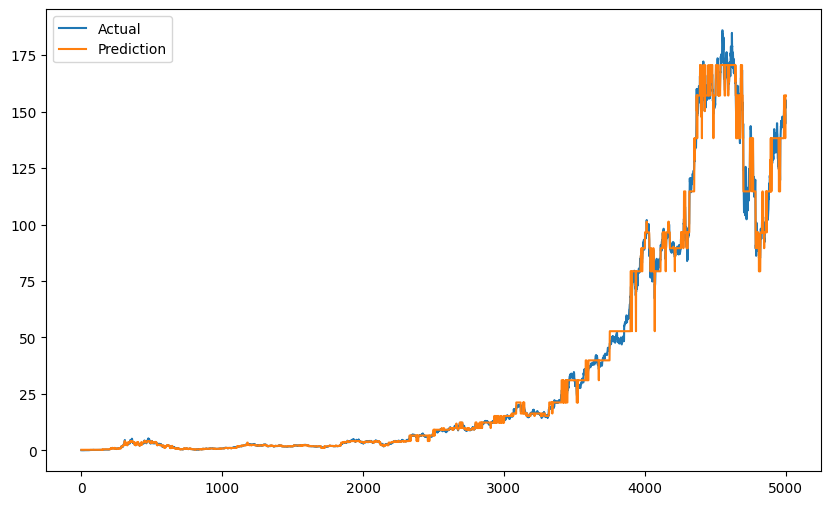

In [121]:
plt.figure(figsize=(10, 6))
plt.plot(pandas_df3['Close'], label='Actual')
plt.plot(pandas_df3['Prediction'], label='Prediction')
plt.legend()
plt.show()

Linear Regression model

In [94]:
pandas_df = pred_train1.select("Close", "Prediction").toPandas()

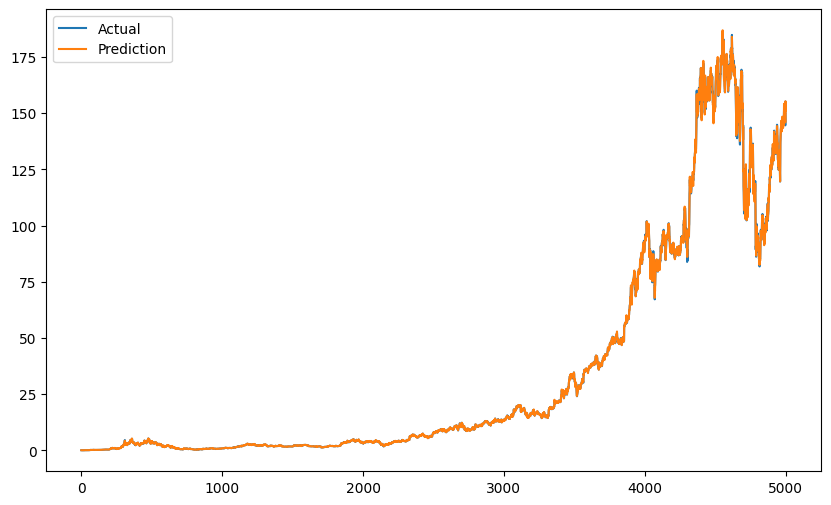

In [95]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(pandas_df['Close'], label='Actual')
plt.plot(pandas_df['Prediction'], label='Prediction')
plt.legend()
plt.show()

In [96]:
lr_model.write().overwrite().save("Model")

In [97]:
from pyspark.ml.regression import LinearRegressionModel
lrModel=LinearRegressionModel.load("Model")
final_output=lrModel.transform(test_data)
final_output.show()

Py4JJavaError: An error occurred while calling o1759.load.
: java.lang.UnsatisfiedLinkError: org.apache.hadoop.io.nativeio.NativeIO$POSIX.stat(Ljava/lang/String;)Lorg/apache/hadoop/io/nativeio/NativeIO$POSIX$Stat;
	at org.apache.hadoop.io.nativeio.NativeIO$POSIX.stat(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$POSIX.getStat(NativeIO.java:608)
	at org.apache.hadoop.fs.RawLocalFileSystem$DeprecatedRawLocalFileStatus.loadPermissionInfoByNativeIO(RawLocalFileSystem.java:934)
	at org.apache.hadoop.fs.RawLocalFileSystem$DeprecatedRawLocalFileStatus.loadPermissionInfo(RawLocalFileSystem.java:848)
	at org.apache.hadoop.fs.RawLocalFileSystem$DeprecatedRawLocalFileStatus.getPermission(RawLocalFileSystem.java:816)
	at org.apache.hadoop.fs.LocatedFileStatus.<init>(LocatedFileStatus.java:52)
	at org.apache.hadoop.fs.FileSystem$4.next(FileSystem.java:2199)
	at org.apache.hadoop.fs.FileSystem$4.next(FileSystem.java:2179)
	at org.apache.hadoop.mapred.FileInputFormat.singleThreadedListStatus(FileInputFormat.java:287)
	at org.apache.hadoop.mapred.FileInputFormat.listStatus(FileInputFormat.java:244)
	at org.apache.hadoop.mapred.FileInputFormat.getSplits(FileInputFormat.java:332)
	at org.apache.spark.rdd.HadoopRDD.getPartitions(HadoopRDD.scala:208)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:291)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:287)
	at org.apache.spark.rdd.MapPartitionsRDD.getPartitions(MapPartitionsRDD.scala:49)
	at org.apache.spark.rdd.RDD.$anonfun$partitions$2(RDD.scala:291)
	at scala.Option.getOrElse(Option.scala:189)
	at org.apache.spark.rdd.RDD.partitions(RDD.scala:287)
	at org.apache.spark.rdd.RDD.$anonfun$take$1(RDD.scala:1468)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.take(RDD.scala:1462)
	at org.apache.spark.rdd.RDD.$anonfun$first$1(RDD.scala:1503)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:407)
	at org.apache.spark.rdd.RDD.first(RDD.scala:1503)
	at org.apache.spark.ml.util.DefaultParamsReader$.loadMetadata(ReadWrite.scala:587)
	at org.apache.spark.ml.regression.LinearRegressionModel$LinearRegressionModelReader.load(LinearRegression.scala:830)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:374)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.lang.Thread.run(Thread.java:750)
